In [3]:
#This header file contains all the common packages
%run /home/cz136/project/sa/lib/header.ipynb
phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
phi_w_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
e_list=np.load("/home/cz136/project/sa/data/e_array.npy")

In [4]:
print(len(clusters))
print(len(shapes))

7001
394334


In [5]:
def drop_poor_centers():
    """Drop clusters with no center shape data from the cluster dataframe"""
    center_id=clusters[('Alt', 'Alt1', 'ID_CENT')]
    pp=shapes.loc[center_id][('All','PP')].to_numpy()
    missing_mem_match_id=clusters[np.isnan(pp)].index
    clusters.drop(missing_mem_match_id,inplace=True)
    np.save("/home/cz136/project/sa/data/missing_centers.npy",center_id[np.isnan(pp)].to_numpy())
    print("The number of clusters with no center shape data {}".format(np.sum(np.isnan(pp))))
    print("The number of clusters with low probability center {}".format(np.sum(pp[~np.isnan(pp)]<=0.55)))
drop_poor_centers()

The number of clusters with no center shape data 0
The number of clusters with low probability center 3


In [6]:
# Print the numbers of galaxies that needed to be masked


print(np.sum(shapes[('All','e1')]==-9999))
print(np.sum(shapes[('All','e2')]==-9999))
print(np.sum(shapes['All','flags_select']==0))
print(np.sum(shapes[('All','PP')]<=0.55))

17512
17512
262867
138875


In [7]:
#masking


shapes=shapes[shapes[('All','PP')]>=0.55]
# shapes=shapes[shapes[('All','e1')]!=-9999]
# shapes=shapes[shapes[('All','e2')]!=-9999]
shapes=shapes[shapes[('All', 'flags_select')]==0]


print(len(clusters))
print(len(shapes))

7001
170325


# Stats of e1,e2

count    170325.000000
mean         -0.000083
std           0.149956
min          -0.696383
25%          -0.077844
50%          -0.000126
75%           0.077556
max           0.775665
Name: (All, e2), dtype: float64

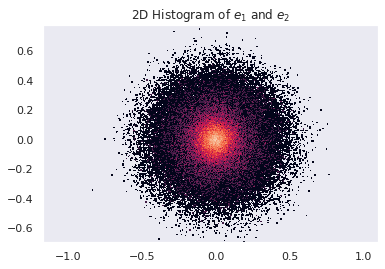

In [8]:
from matplotlib.colors import LogNorm 
plt.hist2d(shapes['All','e1'],shapes['All','e2'],bins=500,norm=LogNorm())
plt.axis('equal')
plt.title("2D Histogram of $e_1$ and $e_2$")
pd.Series(shapes['All','e1']).describe()
pd.Series(shapes['All','e2']).describe()

count    1.703250e+05
mean     9.211162e+00
std      3.583712e+03
min     -9.080580e+04
25%     -1.014232e+00
50%     -7.791543e-04
75%      1.007095e+00
max      1.471856e+06
dtype: float64

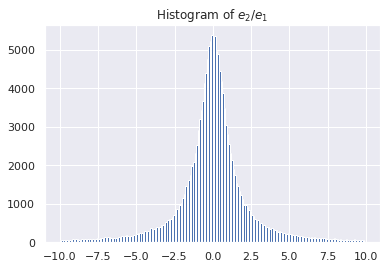

In [9]:
#statistics and hisgoram of e2/e1
plt.hist(shapes['All','e2']/shapes['All','e1'],bins=np.arange(-10,10,0.1))
plt.title("Histogram of $e_2$/$e_1$")
pd.Series(shapes['All','e2']/shapes['All','e1']).describe()

# Get phi 

In [10]:
def get_std_err_of_mean(np_array):
    mean=np_array.mean()
    std=np_array.std()
    n=len(np_array)
    return(std/np.sqrt(n))

In [11]:
def get_theta_for_obj(obj1,obj2):
    
    """Theta is the position angle of obj2 from north of east of obj1 """
    
    ra1,dec1=(obj1[('All', 'RA')],obj1[('All', 'DEC')])
    ra2,dec2=(obj2[('All', 'RA')],obj2[('All', 'DEC')])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)
    

In [12]:
def get_pa_for_obj(obj):
    e1=obj['All']['e1']
    e2=obj['All']['e1']
    
    α =0.5*np.arctan2(-e2,-e1)*180/np.pi
    return(α)

In [13]:
error_list_phi=[]
error_list_e=[]

def get_phi_for_cluster(cluster):
    
    """Input: cluster series
        Output: an array of position angle weighted by PP
        Record KeyError in an array (usually caused by uncomplete shape catalog).
    """
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]



        pa=np.array([get_pa_for_obj(member[1]) for member in members.iterrows()]).flatten()
        theta= np.array([get_theta_for_obj(member[1],center) for member in members.iterrows()]).flatten()
        pp=members[('All','PP')]
        phi=(pa-theta)
        phi_w=(pa-theta)*pp
    #     print(center.index)
        return(phi,phi_w)    
    except KeyError as e:
        error_list_phi.append(e)
        return(np.array([]),np.array([]))

In [14]:
phi_list=[]
phi_w_list=[]
for mem_matching_id in tqdm(clusters.index):
    phi_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[0]
    phi_w_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[1]
    phi_w_list.append(phi_w_array)
    phi_list.append(phi_array)
phi_list=np.array(phi_list)
phi_w_list=np.array(phi_w_list)

In [15]:
def process_phi(phi_list):

    phi_1d=np.concatenate(phi_list)

    phi_1d=np.where(phi_1d<=0,-phi_1d,phi_1d)
    phi_1d=np.where(phi_1d>=180,phi_1d-180,phi_1d)
    phi_1d=np.where(phi_1d>=90,180-phi_1d,phi_1d)

    phi_1d=np.sort(phi_1d)
    
    return(phi_1d)

phi_1d=process_phi(phi_list)
phi_w_1d=process_phi(phi_w_list)

In [16]:
np.save("/home/cz136/project/sa/data/phi_1d.npy",phi_1d)
np.save("/home/cz136/project/sa/data/phi_w_1d.npy",phi_w_1d)

## Stats for unweighted 

In [17]:
# phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
pd.Series(phi_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.518603e+01 
StdE:7.970490e-02 


count    104848.000000
mean         45.186029
std          25.808762
min           0.000277
25%          22.500000
50%          45.281651
75%          67.500000
max          89.998205
dtype: float64

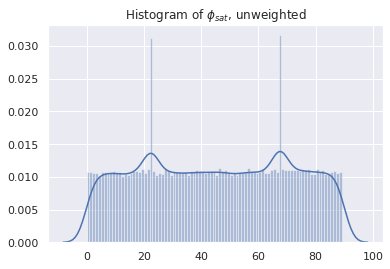

In [18]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$, unweighted") 
pd.Series(phi_1d).describe()

## Stats for weighted

In [19]:
pd.Series(phi_w_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.518603e+01 
StdE:7.970490e-02 


count    104848.000000
mean         44.950438
std          25.804330
min           0.000228
25%          22.500000
50%          44.773097
75%          67.500000
max          89.998497
dtype: float64

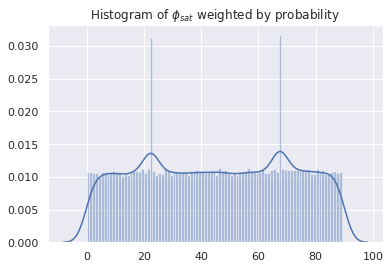

In [20]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$ weighted by probability") 
pd.Series(phi_w_1d).describe()

# Analysis around 22.5 and 67.5

In [21]:
#Print out the most crowded bins

phi_count=np.histogram(phi_1d,bins=BINS)
sort=np.argsort(-phi_count[0])
print(phi_count[1][sort])
print(phi_count[0][sort])

[67 22 56 46 27 77 65 21 68 80 75 61 19 70 69 38 76 71 73 72 48 82 64 30
 81 28 17 43 40 74 44 36 86 47  9 23 16 39 85 60 66 42 55 11 34 37  1  8
  5 32 10 31 58  0 88  6 57 18 63 49 20 53  2 51 62 25 54 87 59 15 33 41
  3 26 84 13 83  7 79 78 29 14 24 35 50 45 52  4 12]
[3285 3237 1184 1180 1170 1170 1168 1167 1166 1162 1161 1160 1156 1154
 1153 1152 1152 1148 1147 1147 1145 1142 1139 1136 1135 1135 1133 1132
 1131 1131 1130 1129 1129 1128 1126 1125 1124 1124 1123 1122 1119 1116
 1116 1115 1115 1114 1114 1113 1112 1112 1112 1112 1111 1111 1111 1109
 1108 1108 1107 1106 1106 1105 1104 1104 1104 1104 1102 1099 1098 1098
 1095 1093 1093 1091 1091 1086 1086 1085 1084 1082 1073 1072 1067 1065
 1064 1064 1061 1057 1051]


count    3285.000000
mean       22.507348
std         0.177324
min        22.001433
25%        22.500000
50%        22.500000
75%        22.500000
max        23.046684
dtype: float64

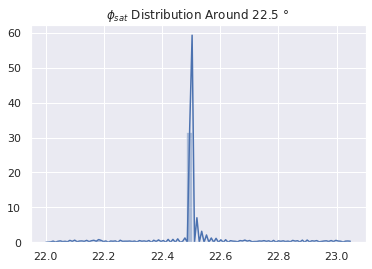

In [22]:
#Statistics around 22.5
first_cluster_left=np.sum(phi_count[0][0:22])
first_length=phi_count[0][sort][0]
first_cluster=phi_1d[first_cluster_left:first_cluster_left+first_length]
ax = sns.distplot(first_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 22.5 $\degree$")
pd.Series(first_cluster).describe()

count    3285.000000
mean       67.502562
std         0.167488
min        67.000614
25%        67.500000
50%        67.500000
75%        67.500000
max        67.999551
dtype: float64

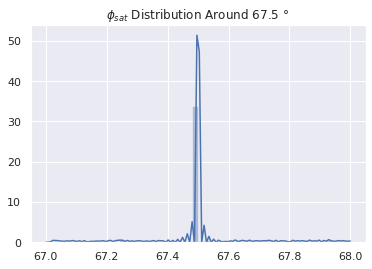

In [23]:
second_cluster_left=np.sum(phi_count[0][0:67])
second_length=phi_count[0][sort][0]
second_cluster=phi_1d[second_cluster_left:second_cluster_left+second_length]
ax = sns.distplot(second_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 67.5 $\degree$")
pd.Series(second_cluster).describe()

# Get e

## Statistics of e1 and e2

In [43]:
e1=shapes[('All','e1')].to_numpy()
shapes[('All','e1')].describe()

count    170325.000000
mean         -0.000072
std           0.149237
min          -0.838272
25%          -0.076783
50%          -0.000302
75%           0.076532
max           0.767894
Name: (All, e1), dtype: float64

In [44]:
e2=shapes[('All','e1')].to_numpy()
shapes[('All','e2')].describe()

count    170325.000000
mean         -0.000083
std           0.149956
min          -0.696383
25%          -0.077844
50%          -0.000126
75%           0.077556
max           0.775665
Name: (All, e2), dtype: float64

In [49]:
def get_e_for_pair(cen,sat):
    e=np.sqrt(sat[('All','e1')]**2+sat[('All','e2')]**2)
    delta=get_theta_for_obj(cen,sat)
    alpha=get_pa_for_obj(sat)
    ep,ex=(e*np.cos(2*(delta-alpha)),e*np.sin(2*(delta-alpha)))
    return(ep,ex)

In [50]:
def get_e_for_cluster(cluster):
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]

        e_array=np.array([(get_e_for_pair(center,member[1])) for member in members.iterrows()])
        return(e_array)    
    except KeyError as e:
        error_list_e.append(e)
        return(np.array([]))

In [51]:
e_list=[]
for mem_matching_id in tqdm(clusters.index[:]):
    e_array=get_e_for_cluster(clusters.loc[mem_matching_id])
    e_list.append(e_array)
e_list=np.array(e_list)
e_list=np.concatenate([e_array for e_array in e_list if e_array!=np.array([])])

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [52]:
np.save("/home/cz136/project/sa/data/e_array",e_list)

In [53]:
e_p_1d=e_list[:,0].flatten()
e_x_1d=e_list[:,1].flatten()

mean=-7.987008e-04, std_mean=4.633497e-04


count    104848.000000
mean         -0.000799
std           0.150034
min          -0.705929
25%          -0.079479
50%          -0.000332
75%           0.076972
max           0.684332
dtype: float64

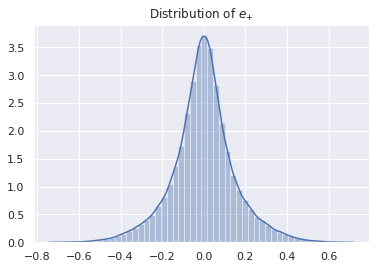

In [54]:
ax=sns.distplot(e_p_1d)
ax.set_title("Distribution of $e_{+}$")
print ("mean={:05e}, std_mean={:05e}".format(e_p_1d.mean(),get_std_err_of_mean(e_p_1d)))
pd.Series(e_p_1d).describe()

mean=1.584812e-03, std_mean=4.596150e-04


count    104848.000000
mean          0.001585
std           0.148825
min          -0.750668
25%          -0.073790
50%           0.004342
75%           0.077084
max           0.766395
dtype: float64

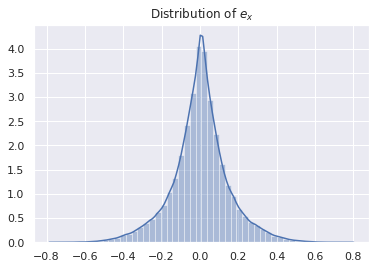

In [55]:
ax=sns.distplot(e_x_1d)
ax.set_title("Distribution of $e_{x}$")
print ("mean={:05e}, std_mean={:05e}".format(e_x_1d.mean(),get_std_err_of_mean(e_x_1d)))
pd.Series(e_x_1d).describe()

# Analysis

It seems the only things unexpected are the features around 22.5 and 67.5 degrees and the non-zero mean of ex.